Entropic Regularization of Optimal Transport
============================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This numerical tours exposes the general methodology of regularizing the
optimal transport (OT) linear program using entropy. This allows to
derive fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.
$$ \DeclareMathOperator{\KL}{KL}
\newcommand{\KLdiv}[2]{\KL\pa{#1 | #2}}
\newcommand{\KLproj}{P^{\tiny\KL}}
\def\ones{\mathbb{I}} $$

In [1]:
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)

for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}

for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

source("nt_toolbox/toolbox_wavelet_meshes/meshgrid.R")
options(repr.plot.width=3.5, repr.plot.height=3.5)

Loading required package: plyr
Loading required package: magrittr

Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image



Entropic Regularization of Optimal Transport
--------------------------------------------
We consider two input histograms $p,q \in \Si_N$, where we denote the simplex in $\RR^N$
$$ \Si_{N} \eqdef \enscond{ p \in (\RR^+)^N }{ \sum_i p_i = 1 }.  $$
We consider the following discrete regularized transport
$$  W_\ga(p,q) \eqdef \umin{\pi \in \Pi(p,q)} \dotp{C}{\pi} - \ga E(\pi).  $$
where the polytope of coupling is defined as
$$ \Pi(p,q) \eqdef \enscond{\pi \in (\RR^+)^{N \times N}}{ \pi \ones = p, \pi^T \ones = q },  $$
where $ \ones \eqdef (1,\ldots,1)^T \in \RR^N $,
and for $\pi \in (\RR^+)^{N \times N}$, we define its entropy as
$$ E(\pi) \eqdef - \sum_{i,j} \pi_{i,j} ( \log(\pi_{i,j}) - 1). $$


When $\ga=0$ one recovers the classical (discrete) optimal transport.
We refer to the monograph [Villani](#biblio) for more details about OT.
The idea of regularizing transport to allows for faster computation is
introduced in [Cuturi](#biblio).


Here the matrix $C \in (\RR^+)^{N \times N} $ defines the ground cost, i.e.
$C_{i,j}$ is the cost of moving mass from a bin indexed by $i$ to a bin indexed by $j$.


The regularized transportation problem can be re-written as a projection
$$ W_\ga(p,q) = \ga \umin{\pi \in \Pi(p,q)} \KLdiv{\pi}{\xi}
	\qwhereq
	\xi_{i,j} = e^{ -\frac{C_{i,j}}{\ga} }  $$
of $\xi$ according to the Kullback-Leibler divergence.
The Kullback-Leibler divergence between $\pi, \xi \in (\RR^+)^P$ is
$$ \KLdiv{\pi}{\xi} = \sum_{i,j} \pi_{i,j} \pa{ \log\pa{ \frac{\pi_{i,j}}{\xi_{i,j}} } - 1}. $$


This interpretation of regularized transport as a KL projection and its numerical
applications are detailed in [BenamouEtAl](#biblio).


Given a convex set $\Cc \subset \RR^N$, the projection according to the Kullback-Leiber divergence is defined as
$$ \KLproj_\Cc(\xi) = \uargmin{ \pi \in \Cc } \KLdiv{\pi}{\xi}. $$

Iterative Bregman Projection Algorithm
--------------------------------------
Given affine constraint sets $ (\Cc_1,\ldots,\Cc_K) $, we aim at computing
$$   \KLproj_\Cc(\xi) \qwhereq \Cc = \Cc_1 \cap \ldots \cap \Cc_K. $$


This can be achieved, starting by $\pi_0=\xi$, by iterating
$$ \forall \ell \geq 0, \quad \pi_{\ell+1} =  \KLproj_{\Cc_\ell}(\pi_\ell), $$
where the index of the constraints should be understood modulo $K$,
i.e. we set $ \Cc_{\ell+K}=\Cc_\ell $.


One can indeed show that $\pi_\ell \rightarrow \KLproj_\Cc(\bar \pi)$.
We refer to [BauschkeLewis](#biblio) for more details about this
algorithm and its extension to compute the projection on the intersection of
convex sets (Dikstra algorithm).

Iterative Projection for Regularized Transport aka Sinkhorn's Algorithm
-----------------------------------------------------------------------
We can re-cast the regularized optimal transport problem within this
framework by introducing
$$ \Cc_1 \eqdef \enscond{\pi \in (\RR^+)^{N \times N} }{\pi \ones = p}
\qandq
 \Cc_2 \eqdef \enscond{\pi \in (\RR^+)^{N \times N} }{\pi^T \ones = q}. $$


The KL projection on $\Cc_1$ sets are easily computed by divisive
normalization of rows. Indeed, denoting
$ \pi = \KLproj_{\Cc_1}(\bar \pi) $, one has
$$ \forall (i,j), \quad
  \pi_{i,j} = \frac{ p_i \bar\pi_{i,j} }{ \sum_{s} \bar\pi_{i,s} } $$
and similarely for $\KLproj_{\Cc_1}(\bar \pi) $ by replacing rows by
colums.


A fundamental remark is that, if $\bar\pi = \diag(a) \xi \diag(b)$ (a
so-called diagonal scaling of the kernel $\xi$), then one has
$$ \KLproj_{\Cc_1}(\bar \pi) = \diag(\tilde a) \xi \diag(b)
  \qandq
  \KLproj_{\Cc_2}(\bar \pi) = \diag(a) \xi \diag(\tilde b)$$
 where the new scaling reads
  $$ \tilde a = \frac{p}{\xi(b)}  \qandq  \tilde b = \frac{q}{\xi^T(a)} $$
where $\frac{\cdot}{\cdot}$ is entry-wise division.


This means that the iterates of Bregman iterative projections, starting
with $ a_0 \eqdef \ones $ always have the form
$ \pi_\ell = \diag(a_\ell) \xi \diag(b_\ell)  $
and these diagonal scaling weights are updated as follow
$$  a_{\ell+1} \eqdef \frac{p}{\xi(b_\ell)}
      \qandq
  b_{\ell+1} \eqdef \frac{q}{\xi^T(a_{\ell+1})}. $$
This algorithm is in fact the well known Sinkhorn algorithm [Sinkhorn](#biblio).

Transport Between Point Clouds
------------------------------
We first test the method for two input measures that are uniform measures
(i.e. constant histograms) supported on two point clouds
(that do not necessarily have the same size).


We thus first load two points clouds $x=(x_i)_{i=1}^{N_1}, y=(y_i)_{i=1}^{N_2}, $
where $x_i, y_i \in \RR^2$.


Number of points in each cloud.

In [2]:
N <- c(300,200)

Dimension of the clouds.

In [3]:
d <- 2

Point cloud $x$, of $N_1$ points inside a square.

In [4]:
x <- array(runif(2*N[1]), c(2,N[1])) - .5

Point cloud $y$, of $N_2$ points inside an anulus.

In [5]:
theta <- 2*pi*array(runif(1*N[2]), c(1,N[2]))
r <- .8 + .2*array(runif(1*N[2]), c(1,N[2]))
y <- rbind(cos(theta)*r, sin(theta)*r)

Shortcut for displaying point clouds.

In [6]:
plotp <- function(x, col){ points(x[1,],x[2,], pch=21, cex=2, col="black", bg=col, lwd=2) }

Display of the two clouds.

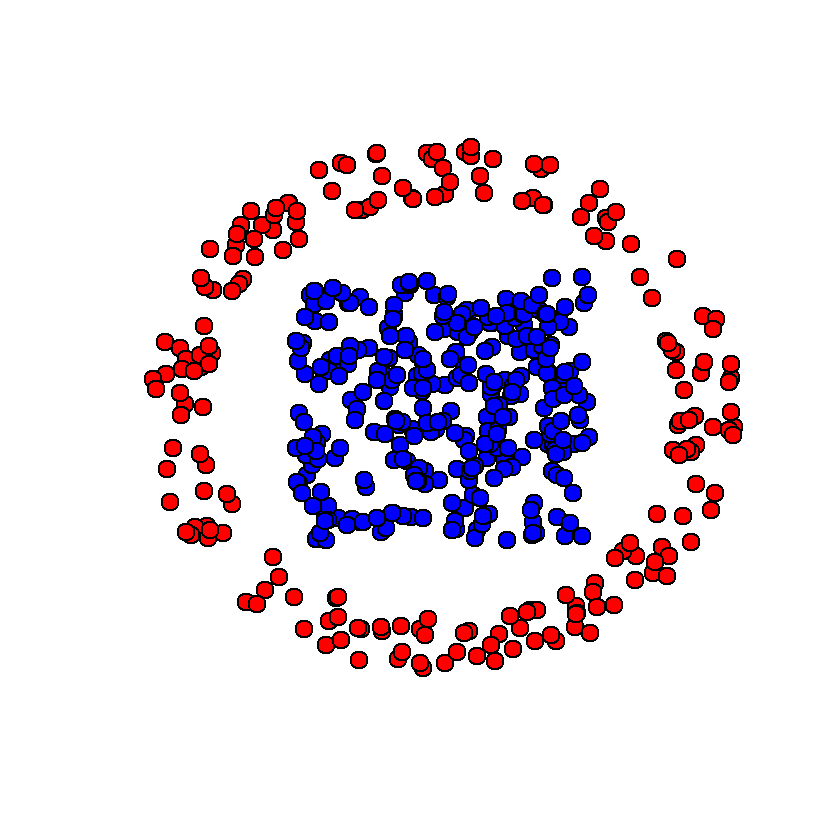

In [7]:
options(repr.plot.width=7, repr.plot.height=7)

plot(1, type="n", axes=F, xlab="", ylab="",
     xlim=c(min(y[1,])-.1, max(y[1,])+.1),
     ylim=c(min(y[2,])-.1, max(y[2,])+.1))

plotp(x, 'blue')
plotp(y, 'red')

Cost matrix $C_{i,j} = \norm{x_i-y_j}^2$.

In [8]:
x2 <- apply(x**2, 2, sum)
y2 <- apply(y**2, 2, sum)
C <- array(rep(y2, each=N[1]), c(N[1], N[2])) + array(rep(x2, times=N[2]), c(N[1], N[2])) - 2*t(x)%*%y

Target histograms, here uniform histograms.

In [9]:
p <- rep(1, N[1])/N[1]
q <- rep(1, N[2])/N[2]

Regularization strength $\ga$.

In [10]:
gamma <- .01

Gibbs Kernel.

In [11]:
xi <- exp(-C/gamma)

Initialization of $b_0=\ones_{N_2}$ ($a_0$ does not need to be
initialized).

In [12]:
b <- rep(1, N[2])

One sinkhorn iterations.

In [13]:
a <- p/(xi%*%b)
b <- q /(t(xi)%*%a)

__Exercise 1__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$ \norm{ \pi \ones - p }, \norm{ \pi^T \ones - q } $
(you need to think about how to compute these residuals from $(a,b)$ alone).
isplay the violation of constraint error in log-plot.

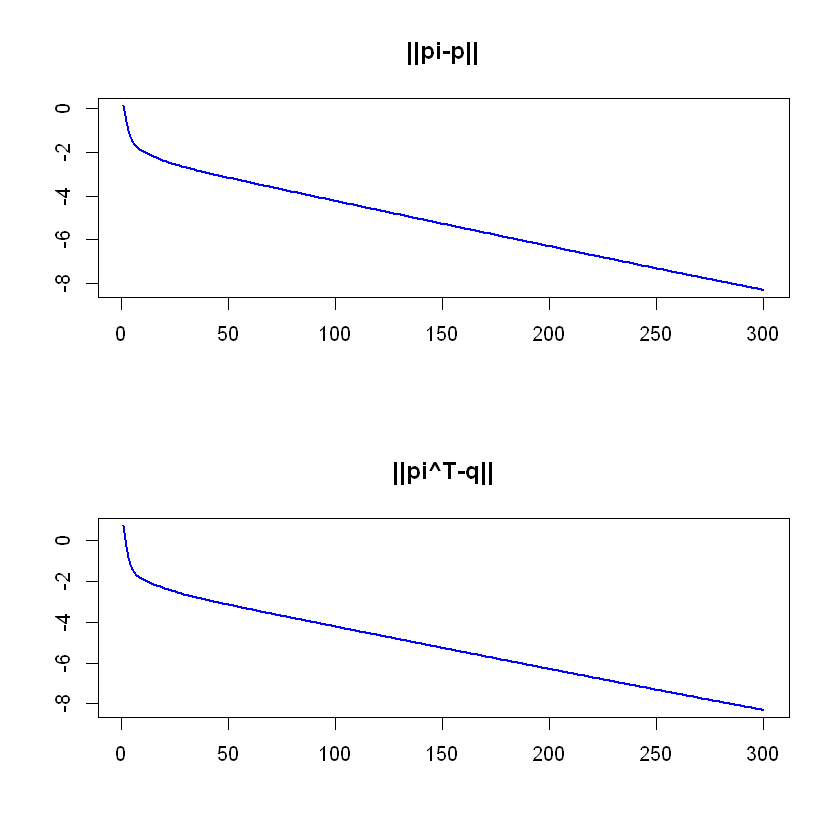

In [14]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/optimaltransp_5_entropic/exo1.R")

In [15]:
# Insert your code here.

Compute the final matrix.

In [16]:
a_diag <- array(0, c(length(a), length(a)))
diag(a_diag) <- a

b_diag <- array(0, c(length(b), length(b)))
diag(b_diag) <- b

Pi <- (a_diag %*% xi) %*% b_diag

Display it.

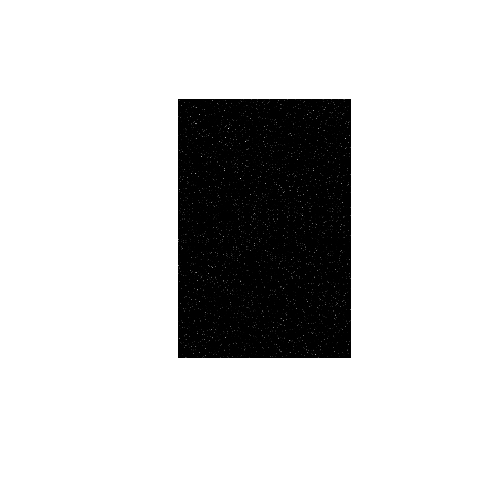

In [17]:
options(repr.plot.width=4, repr.plot.height=4)

imageplot(Pi)

__Exercise 2__

Display the regularized transport solution for various values of $\gamma$.
For a too small value of $\gamma$, what do you observe ?

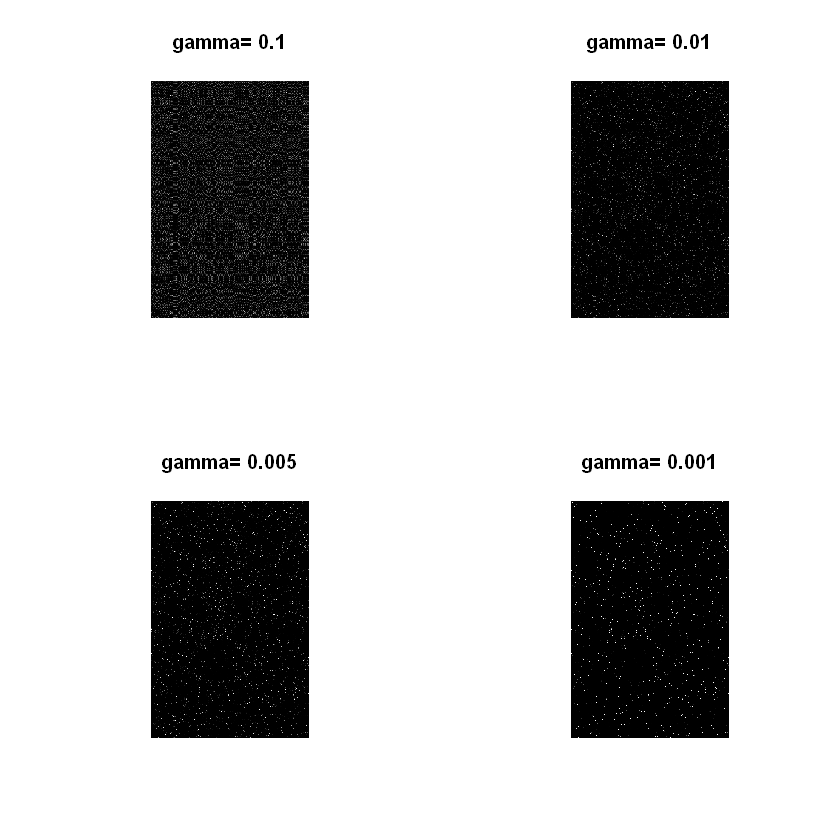

In [18]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/optimaltransp_5_entropic/exo2.R")

In [19]:
# Insert your code here.

Compute the obtained optimal $\pi$.

In [20]:
a_diag <- array(0, c(length(a), length(a)))
diag(a_diag) <- a

b_diag <- array(0, c(length(b), length(b)))
diag(b_diag) <- b

Pi <- (a_diag %*% xi) %*% b_diag

Keep only the highest entries of the coupling matrix, and use them to
draw a map between the two clouds.
First we draw "strong" connexions, i.e. linkds $(i,j)$ corresponding to
large values of $\pi_{i,j}$.
We then draw weaker connexions.

In [21]:
nonzero <- function(X){
    n_r <- dim(X)[1]
    idx <- which(X != 0)
    I <- mod(idx-1,n_r)+1
    J <- ceiling(idx/n_r)
    return(list(I=I, J=J))
}

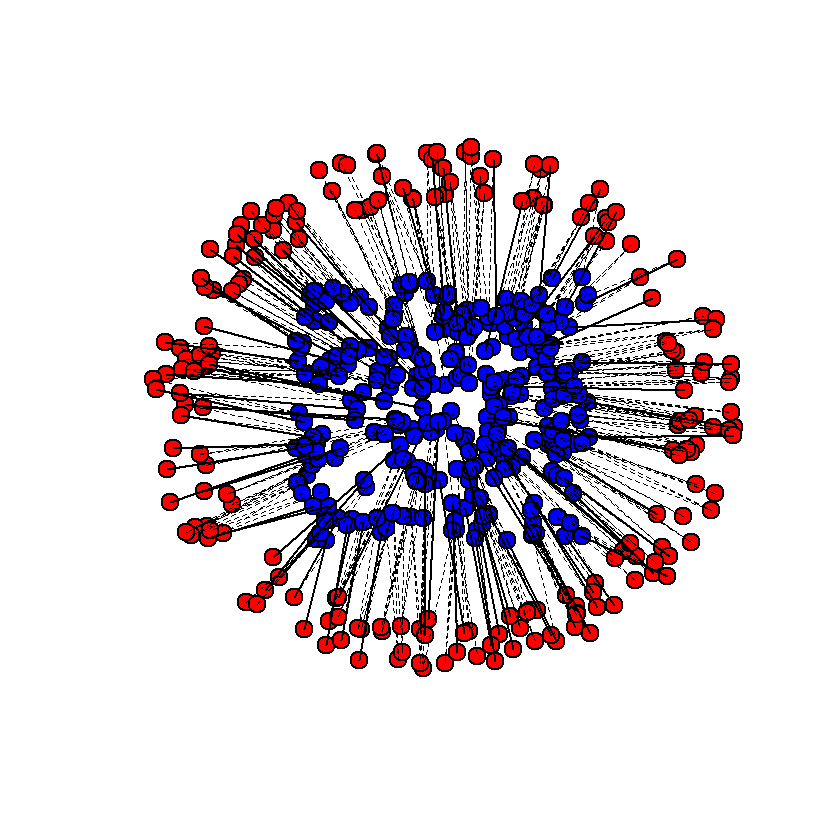

In [22]:
options(repr.plot.width=7, repr.plot.height=7)

plot(1, type="n", axes=F, xlab="", ylab="",
     xlim=c(min(y[1,])-.1, max(y[1,])+.1),
     ylim=c(min(y[2,])-.1, max(y[2,])+.1))

plotp(x, 'blue')
plotp(y, 'red')

A <- Pi * (Pi > min(1./N)*.7)
nonzero_A <- nonzero(A)
i <- nonzero_A$I ; j <- nonzero_A$J
for (cpl in 1:length(i)){
    lines(c(x[1,i][cpl], y[1,j][cpl]), c(x[2,i][cpl], y[2,j][cpl]), lwd=2)
}


A <- Pi * (Pi > min(1./N)*.3)
nonzero_A <- nonzero(A)
i <- nonzero_A$I ; j <- nonzero_A$J
for (cpl in 1:length(i)){
    lines(c(x[1,i][cpl], y[1,j][cpl]), c(x[2,i][cpl], y[2,j][cpl]), lwd=1, lty=2)
}

Transport Between Histograms
----------------------------
We now consider a different setup, where the histogram values
$p,q$ are not uniform, but the measures are defined on a uniform grid
$x_i=y_i=i/N$. They are thue often refered to as "histograms".


Size $N$ of the histograms.

In [23]:
N <- 200

We use here a 1-D square Euclidean metric.

In [24]:
t <- 0:(N-1)/N

Define the histogram $p,q$ as translated Gaussians.

In [25]:
Gaussian <- function(t0,sigma){ exp(-(t-t0)**2/(2*sigma**2)) }
normalize <- function(p){ p/sum(p) }

sigma <- .06
p <- Gaussian(.25,sigma)
q <- Gaussian(.8,sigma)

Add some minimal mass and normalize.

In [26]:
vmin <- .02
p <- normalize( p+max(p)*vmin)
q <- normalize( q+max(q)*vmin)

Display the histograms.

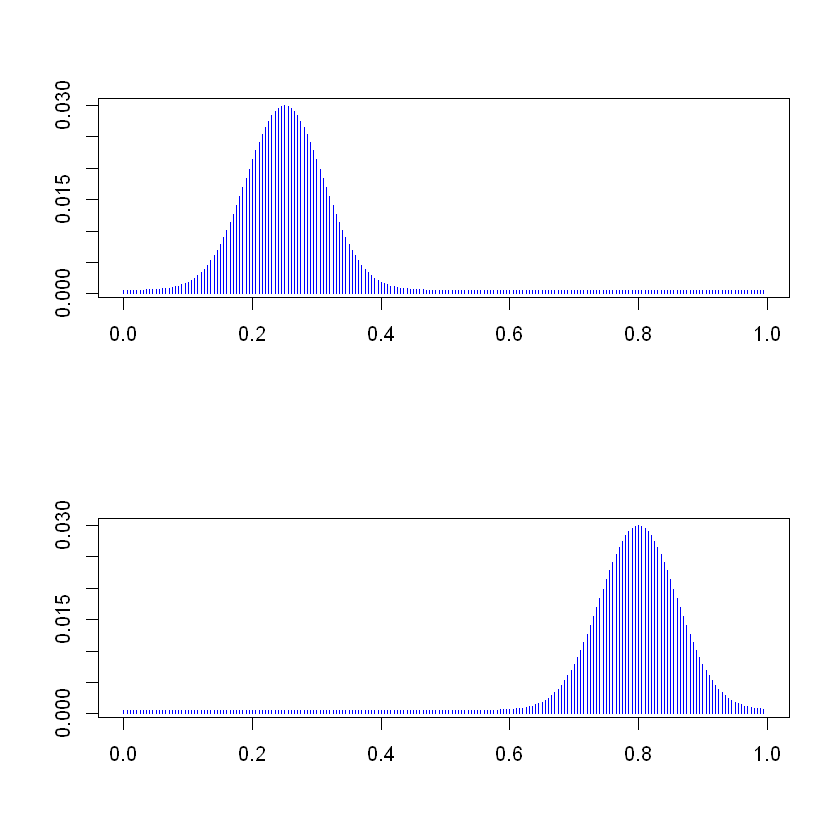

In [27]:
options(repr.plot.width=7, repr.plot.height=7)

par(mfrow=c(2,1))

plot(t, p, col="blue", type="h", xlab="", ylab="")
plot(t, q, col="blue", type="h", xlab="", ylab="")

Regularization strength $\ga$.

In [28]:
gamma <- (.03)**2

The Gibbs kernel is a Gaussian convolution,
$$ \xi_{i,j} = e^{ -(i/N-j/N)^2/\gamma }. $$

In [29]:
grid <- meshgrid_2d(t,t)
Y <- grid$X ; X <- grid$Y
xi <- exp(-(X-Y)**2/gamma)

Initialization of $b_0=\ones_{N}$.

In [30]:
b <- rep(1, N)

One sinkhorn iteration.

In [31]:
a <- p/(xi%*%b)
b <- q /(t(xi)%*%a)

__Exercise 3__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$ \norm{ \pi \ones - p }, \norm{ \pi^T \ones - q } $. You need to think how to compute it from $(a,b)$.
Display the violation of constraint error in log-plot.

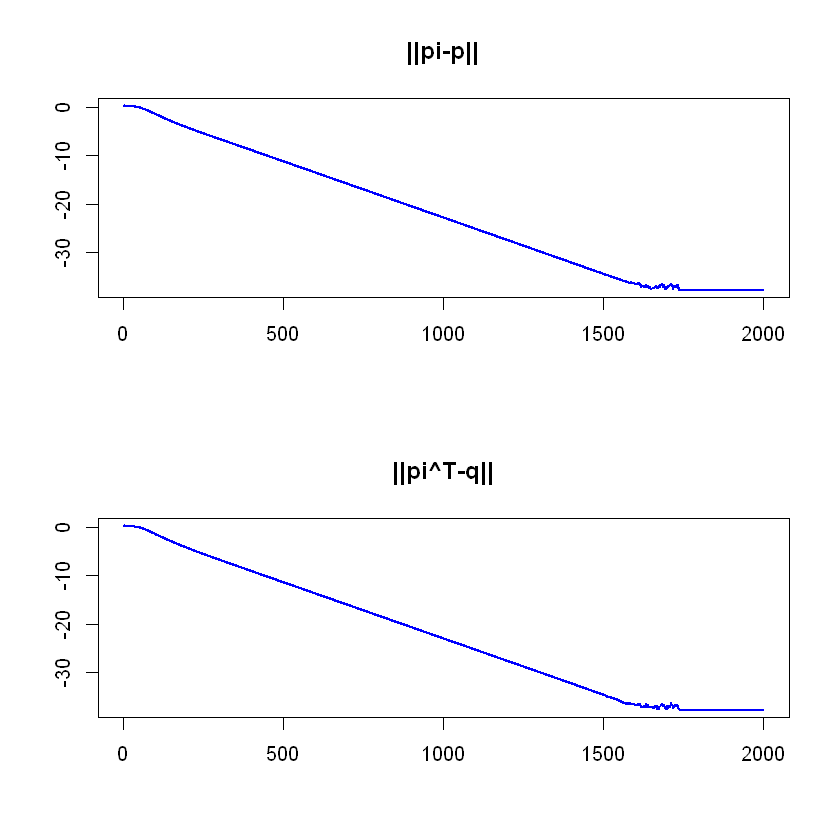

In [32]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/optimaltransp_5_entropic/exo3.R")

In [33]:
# Insert your code here.

Display the coupling. Use a log domain plot to better vizualize it.

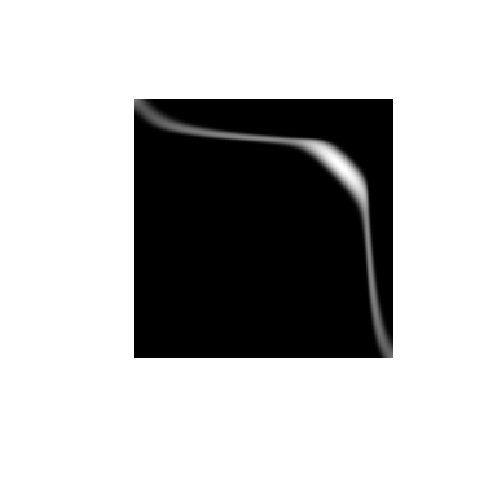

In [34]:
a_diag <- array(0, c(length(a), length(a)))
diag(a_diag) <- a

b_diag <- array(0, c(length(b), length(b)))
diag(b_diag) <- b

Pi <- (a_diag %*% xi) %*% b_diag

options(repr.plot.width=4, repr.plot.height=4)

imageplot(log(Pi+1e-5))

One can compute an approximation of the transport plan
between the two measure by computing the so-called barycentric projection map
$$ t_i \in [0,1] \longmapsto s_j \eqdef \frac{\sum_{j} \pi_{i,j} t_j }{ \sum_{j} \pi_{i,j} }
   =  \frac{ [a \odot \xi(b \odot t)]_j }{ p_i }. $$
where $\odot$ and $\frac{\cdot}{\cdot}$ are the enry-wise multiplication and division.


This computation can thus be done using only multiplication with the
kernel $\xi$.

In [35]:
s <- (xi %*% (b*t))*a/p

Display the transport map, super-imposed over the coupling.

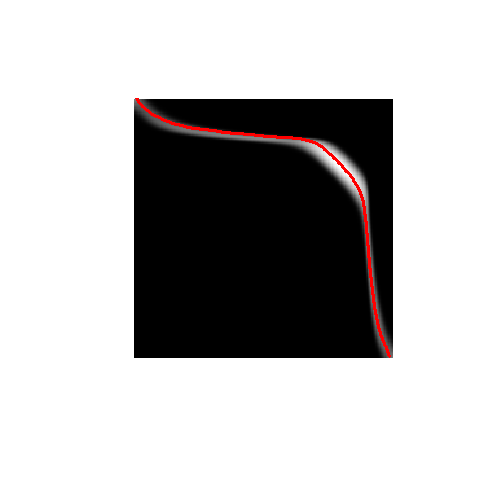

In [36]:
imageplot(log(Pi+1e-5))
lines(s*N,t*N, col='red', lwd=3, xlim=c(0,N), ylim=c(0,N))

Wasserstein Barycenters
-----------------------
Instead of computing transport, we now turn to the problem of computing
barycenter of measures. A barycenter $q$ solves
$$ \umin{q} \sum_{k=1}^K W_\ga(p_k,q)  $$
where $\la_k$ are positive weights with $\sum_k \la_k=1$. This
follows the definition of barycenters proposed in
[AguehCarlier](#biblio).


With of the histograms.

In [37]:
N <- 70

Load input histograms $ (p_k)_{k=1}^K $.

In [38]:
names <- c('disk','twodisks','letter-x','letter-z')
vmin <- .05
P <- array(0, c(N,N,length(names)))
for (i in 1:length(names)){
    p <- as.matrix( load_image(paste("nt_toolbox/data/", names[i],".png",sep=""),N) )
    p <- normalize(rescale(p)+vmin)
    P[,,i] <- p
}

K <- length(names)

Display the input histograms.

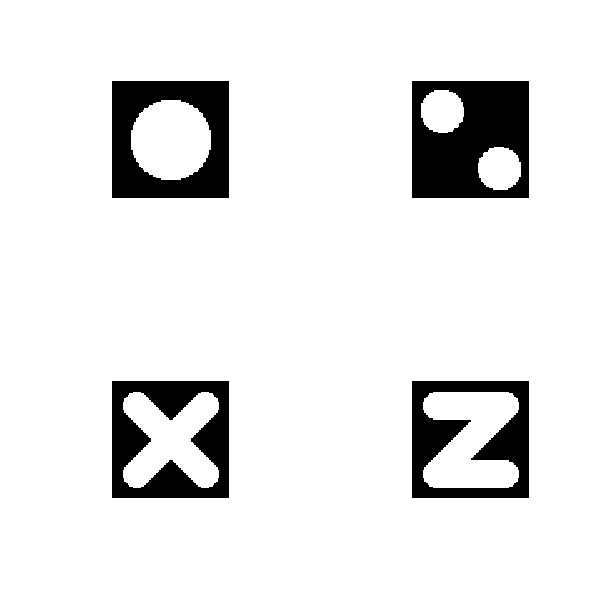

In [39]:
options(repr.plot.width=5, repr.plot.height=5)

for (i in 1:K){
    imageplot(P[,,i], '',c(2,2,i))
}

In this specific case, the kernel $\xi$ associated with the
squared Euclidean norm is a convolution with a Gaussian filter
$$ \xi_{i,j} = e^{ -\norm{i/N-j/N}^2/\gamma } $$
where here $(i,j)$ are 2-D indexes.


The multiplication against the kernel $\xi(a_\ell)$
can now be computed efficiently, using fast convolution methods.
This
crucial points was exploited and generalized in [SolomonEtAl](#biblio)
to design fast optimal transport algorithm.


Regularization strength $\ga$.

In [40]:
gamma <- (.04)**2

Define the $\xi$ kernel.
We use here the fact that the convolution is separable to implement it
using only 1-D convolution, which further speeds up computations.

In [41]:
n <- 41 # width of the convolution kernel
t <- seq(-n/(2*N),n/(2*N),length=n)
g <- exp(-t**2/gamma)
g2 <- g %*% t(g)
xi <- function(x){ t( as.matrix( convolve( as.cimg( t( as.matrix( convolve(as.cimg(x), as.cimg(g2)) ) ) ), as.cimg(g2) ) ) ) }

Display the application of the $\xi$ kernel on one of the input histogram.

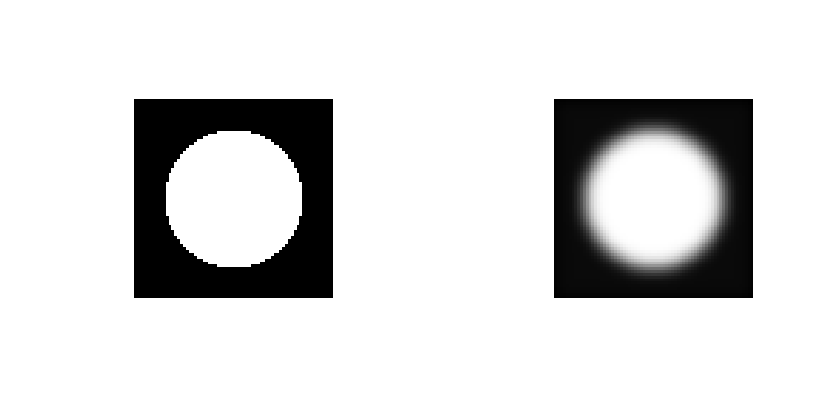

In [42]:
options(repr.plot.width=7, repr.plot.height=3.5)
imageplot(P[,,1],'',c(1,2,1))
imageplot(xi(P[,,1]),'',c(1,2,2))

Weights for isobarycenter.

In [43]:
lambd <- rep(1, K)/K

It is shown in [BenamouEtAl](#biblio) that the problem of Barycenter computation
boilds down to
optimizing over couplings $(\pi_k)_k$, and that this can be achieved
using iterative Bregman projection that defines iterates $(\pi_{k,\ell})_k$.
These iterates can be written using diagonal scalings
$ \pi_{k,\ell} \eqdef \diag(a_{k,\ell}) \xi \diag(b_{k,\ell}). $


Initialize the scaling factors.

In [44]:
b <- array(1, c(N,N,K))
a <- b

The first step of the Bregman projection method corresponds to the
projection on the fixed marginals constraints $\pi_k \ones=p_k$. This
is achieved by updating
$$ \forall k=1,\ldots,K, \quad a_{k,\ell+1} = \frac{p_k}{ \xi( b_{k,\ell} ) }. $$

In [45]:
for (k in 1:K){
    a[,,k] <- P[,,k]/xi(b[,,k])
}

The second step of the Bregman projection method corresponds to the
projection on the equal marginals constraints $\forall k, \pi_k^T \ones=q$. This
is achieved by first computing the target barycenter using a geometric means
$$ \log(q_\ell) \eqdef \sum_k \lambda_k \log( b_{k,\ell} \odot \xi( a_{k,\ell} ) ). $$

In [46]:
q <- rep(0, N)

for (k in 1:K){
    q <- q + lambd[k] * log(pmax(1e-19*rep(1, length(b[,,k])), b[,,k]*xi(a[,,k])))
}

q <- exp(q)

And then one can update the other maginals to be equal to this barycenter at step $\ell$.
$$ \forall k=1,\ldots,K, \quad b_{k,\ell+1} \eqdef \frac{q_\ell}{ \xi(a_{k,\ell+1}) }. $$

In [47]:
for (k in 1:K){
    b[,,k] <- q/xi(a[,,k])
}

__Exercise 4__

Implement the iterative algorithm to compute the iso-barycenter of the measures.
Plot the decay of the error $ \sum_k \norm{\pi_k \ones - p_k} $.

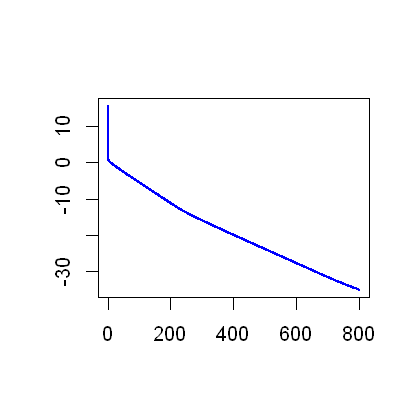

In [48]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

source("nt_solutions/optimaltransp_5_entropic/exo4.R")

In [49]:
# Insert your code here.

Display the barycenter.

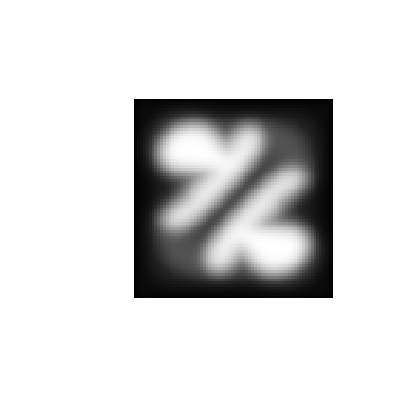

In [50]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

imageplot(as.cimg(q))

__Exercise 5__

Compute barycenters for varying weights $\la$ corresponding to
a bilinear interpolation inside a square.

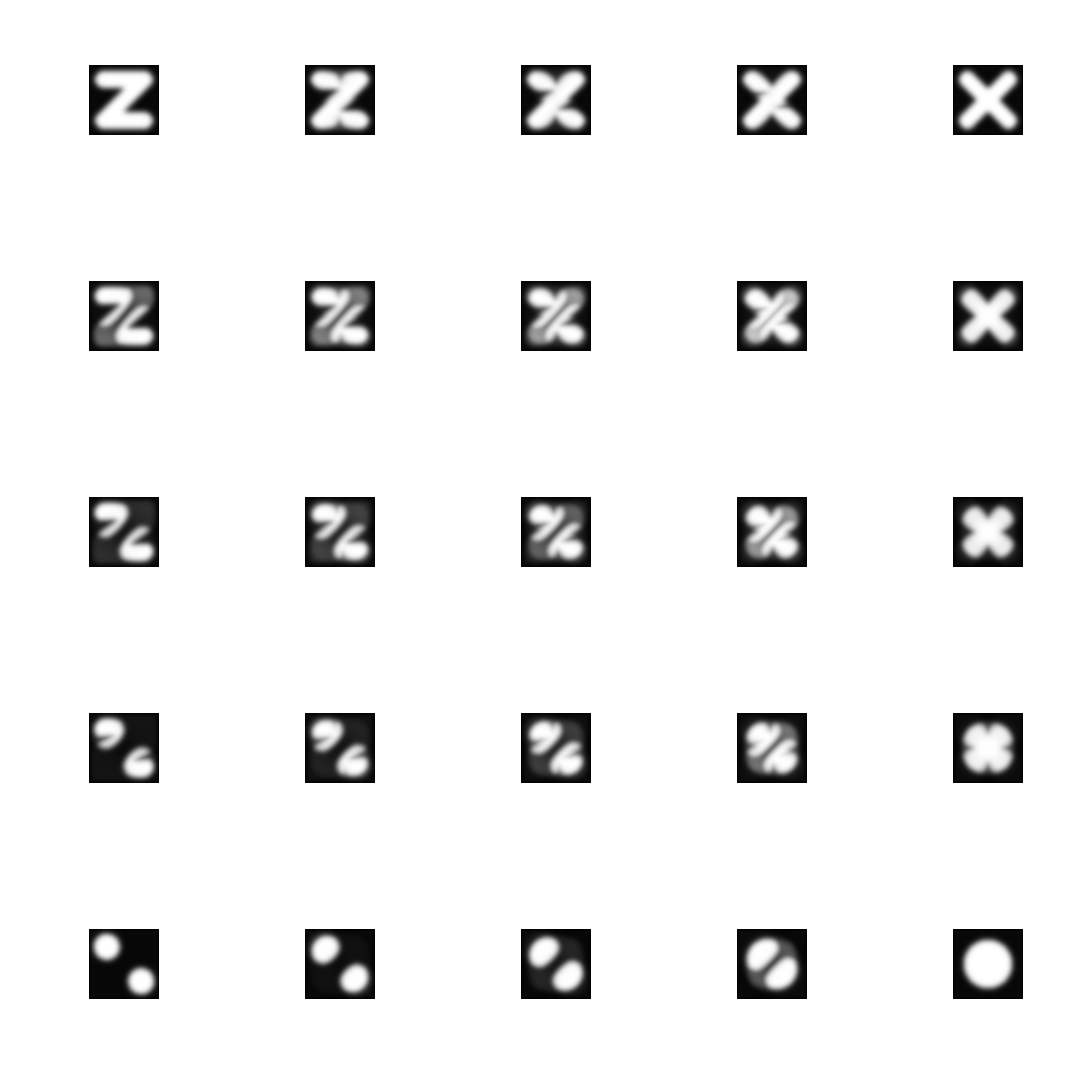

In [51]:
options(repr.plot.width=9, repr.plot.height=9)

source("nt_solutions/optimaltransp_5_entropic/exo5.R")

In [52]:
# Insert your code here.

Bibliography
------------
<html><a name="biblio"></a></html>


* [Villani] C. Villani, (2009). Optimal transport: old and new, volume 338. Springer Verlag.
* [Cuturi] M. Cuturi, (2013). Sinkhorn distances: Lightspeed computation of optimal transport. In Burges, C. J. C., Bottou, L., Ghahramani, Z., and Weinberger, K. Q., editors, Proc. NIPS, pages 2292-2300.
* [AguehCarlier] M. Agueh, and G Carlier, (2011). Barycenters in the Wasserstein space. SIAM J. on Mathematical Analysis, 43(2):904-924.
* [CuturiDoucet] M. Cuturi and A. Doucet (2014). Fast computation of wasserstein barycenters. In Proc. ICML.
* [BauschkeLewis] H. H. Bauschke and A. S. Lewis. Dykstra's algorithm with Bregman projections: a convergence proof. Optimization, 48(4):409-427, 2000.
* [Sinkhorn] R. Sinkhorn. A relationship between arbitrary positive matrices and doubly stochastic matrices. Ann. Math. Statist., 35:876-879, 1964.
* [SolomonEtAl] J. Solomon, F. de Goes, G. Peyr , M. Cuturi, A. Butscher, A. Nguyen, T. Du, and L. Guibas. Convolutional Wasserstein distances: Efficient optimal transportation on geometric domains. Transaction on Graphics, Proc. SIGGRAPH, 2015.
* [BenamouEtAl] J-D. Benamou, G. Carlier, M. Cuturi, L. Nenna, G. Peyr . Iterative Bregman Projections for Regularized Transportation Problems. SIAM Journal on Scientific Computing, 37(2), pp. A1111-A1138, 2015.